# Setup

In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
datasets = ['dutch_census', 'adult', 'german_credit', 'credit_card_clients', 'bank_marketing', 'oulad', 'lawschool']
acc_metrics = ['acc', 'f1', 'gmean']
fair_metrics = ['eo', 'sp']
models = ['FairMOE_0.0', 'FairMOE_1.0', 'MOE_0.0', 'MOE_1.0', 'Mode', 'FairMode',
         'Logistic_Regression', 'Naive_Bayes', 'Decision_Tree', 'KNN', 'Random_Forest', 'LGBM', 'XGB',
          'Agarwal', 'xFAIR', 'Hardt', 'Zafar']

# Predictive Performance Analysis

## Get Performance Ranks DataFrame

In [3]:
acc_dict = {}
for i in range(1,11):
    with open(f'results/results_{i}.json') as fp:
        res = json.load(fp)
    for dataset in datasets:
        for metric in acc_metrics:
            seed = res[dataset]['seed']
            acc_dict[f'{dataset}-{seed}-{metric}'] = {}
            for model in models:
                acc_dict[f'{dataset}-{seed}-{metric}'][model] = res[dataset][model][metric]

In [4]:
perf_df_1 = pd.DataFrame.from_dict(acc_dict)
perf_ranks = perf_df_1.rank(ascending=False)

## Get overall Performance DataFrame

In [5]:
acc_res_dict = {}
acc_res_dict['Dataset'] = []
acc_res_dict['Seed'] = []
acc_res_dict['Model'] = []
acc_res_dict['Time'] = []
acc_res_dict['Accuracy'] = []
acc_res_dict['F1'] = []
acc_res_dict['G-Mean'] = []

for i in range(1,11):
    with open(f'results/results_{i}.json') as fp:
        res = json.load(fp)
    for dataset in res.keys():
        for model in models:
            acc_res_dict['Dataset'].append(dataset)
            acc_res_dict['Seed'].append(res[dataset]['seed'])
            acc_res_dict['Model'].append(model)
            acc_res_dict['Time'].append(res[dataset][model]['time'])
            acc_res_dict['Accuracy'].append(res[dataset][model]['acc'])
            acc_res_dict['F1'].append(res[dataset][model]['f1'])
            acc_res_dict['G-Mean'].append(res[dataset][model]['gmean'])

In [6]:
perf_df = pd.DataFrame.from_dict(acc_res_dict, orient='columns')

In [7]:
perf_graph_dict = {}
perf_graph_dict['Solution'] = []
perf_graph_dict['Score'] = []
perf_graph_dict['Metric'] = []

for i in range(1,11):
    with open(f'results/results_{i}.json') as fp:
        res = json.load(fp)
    for dataset in res.keys():
        for model in models:
            for metric in acc_metrics:
                perf_graph_dict['Solution'].append(model)
                perf_graph_dict['Metric'].append(metric)
                perf_graph_dict['Score'].append(res[dataset][model][metric])

In [8]:
perf_graph_df = pd.DataFrame.from_dict(perf_graph_dict, orient='columns')

# Fairness Analysis

## Get Fairness Ranks DataFrame

In [9]:
fair_dict = {}
for i in range(1,11):
    with open(f'results/results_{i}.json') as fp:
        res = json.load(fp)
    for dataset in datasets:
        seed = res[dataset]['seed']
        for metric in fair_metrics:
            for model in models:
                for prot_attr in res[dataset][model][metric].keys():
                    if f'{dataset}-{seed}-{prot_attr}-{metric}' not in fair_dict:
                        fair_dict[f'{dataset}-{seed}-{prot_attr}-{metric}'] = {}
                    fair_dict[f'{dataset}-{seed}-{prot_attr}-{metric}'][model] = res[dataset][model][metric][prot_attr]

In [10]:
fair_df_1 = pd.DataFrame.from_dict(fair_dict)
fair_ranks = fair_df_1.abs().rank(ascending=True)

## Get overall Fairness DataFrames

In [11]:
fair_res_dict = {}
fair_res_dict['Seed'] = []
fair_res_dict['Dataset'] = []
fair_res_dict['Model'] = []
fair_res_dict['Protected Attribute'] = []
fair_res_dict['Equalized Odds'] = []
fair_res_dict['Statistical Parity'] = []

for i in range(1,11):
    with open(f'results/results_{i}.json') as fp:
        res = json.load(fp)
    for dataset in res.keys():
        for model in models:
            for prot_attr in res[dataset][model]['eo'].keys():
                fair_res_dict['Dataset'].append(dataset)
                fair_res_dict['Seed'].append(res[dataset]['seed'])
                fair_res_dict['Model'].append(model)
                fair_res_dict['Protected Attribute'].append(prot_attr)
                fair_res_dict['Equalized Odds'].append(res[dataset][model]['eo'][prot_attr])
                fair_res_dict['Statistical Parity'].append(res[dataset][model]['sp'][prot_attr])

In [12]:
fair_df = pd.DataFrame.from_dict(fair_res_dict, orient='columns')

In [13]:
fair_graph_dict = {}
fair_graph_dict['Solution'] = []
fair_graph_dict['Score'] = []
fair_graph_dict['Metric'] = []

for i in range(1,11):
    with open(f'results/results_{i}.json') as fp:
        res = json.load(fp)
    for dataset in res.keys():
        for model in models:
            for prot_attr in res[dataset][model]['eo'].keys():
                for metric in fair_metrics:
                    fair_graph_dict['Solution'].append(model)
                    fair_graph_dict['Metric'].append(metric)
                    fair_graph_dict['Score'].append(res[dataset][model][metric][prot_attr])

In [14]:
fair_graph_df = pd.DataFrame.from_dict(fair_graph_dict, orient='columns')

In [15]:
budget_res = pd.DataFrame()
for i in range(1,11):
    with open(f'results/budget_results_{i}.json') as fp:
        res = json.load(fp)
    for dataset in datasets:
        for model in ['FairMOE', 'MOE']:
            temp_df = pd.DataFrame.from_dict(res[dataset][model], orient='index')
            temp_df['Dataset'] = dataset
            temp_df['Model'] = model
            temp_df['Run'] = i
            budget_res = pd.concat([budget_res, temp_df], axis=0)

budget_res = budget_res.reset_index(drop=False, names='Budget')
budget_res['Budget'] = budget_res['Budget'].astype(float)

In [16]:
budget_res.loc[:, 'acc_pct_diff'] = budget_res.apply(lambda x: (x['acc'] - budget_res.loc[(budget_res['Model']==x['Model']) & (budget_res['Run']==x['Run']) & (budget_res['Budget']==0.0) & (budget_res['Dataset']==x['Dataset']), 'acc'].values[0]) * 100 / budget_res.loc[(budget_res['Model']==x['Model']) & (budget_res['Run']==x['Run']) & (budget_res['Budget']==0.0) & (budget_res['Dataset']==x['Dataset']), 'acc'].values[0], axis=1)
budget_res.loc[:, 'f1_pct_diff'] = budget_res.apply(lambda x: ((x['f1'] - budget_res.loc[(budget_res['Model']==x['Model']) & (budget_res['Run']==x['Run']) & (budget_res['Budget']==0.0) & (budget_res['Dataset']==x['Dataset']), 'f1'].values[0]) * 100 / budget_res.loc[(budget_res['Model']==x['Model']) & (budget_res['Run']==x['Run']) & (budget_res['Budget']==0.0) & (budget_res['Dataset']==x['Dataset']), 'f1'].values[0]), axis=1)
budget_res.loc[:, 'gmean_pct_diff'] = budget_res.apply(lambda x: ((x['gmean'] - budget_res.loc[(budget_res['Model']==x['Model']) & (budget_res['Run']==x['Run']) & (budget_res['Budget']==0.0) & (budget_res['Dataset']==x['Dataset']), 'gmean'].values[0]) * 100 / budget_res.loc[(budget_res['Model']==x['Model']) & (budget_res['Run']==x['Run']) & (budget_res['Budget']==0.0) & (budget_res['Dataset']==x['Dataset']), 'gmean'].values[0]), axis=1)

In [17]:
budget_res_fairmoe = budget_res.loc[:, ['Model', 'Dataset', 'Budget', 'acc', 'f1', 'gmean', 'acc_pct_diff', 'f1_pct_diff', 'gmean_pct_diff']].groupby(['Model', 'Budget', 'Dataset']).mean().loc['FairMOE'].reset_index()
budget_res_moe = budget_res.loc[:, ['Model', 'Dataset', 'Budget', 'acc', 'f1', 'gmean', 'acc_pct_diff', 'f1_pct_diff', 'gmean_pct_diff']].groupby(['Model', 'Budget', 'Dataset']).mean().loc['MOE'].reset_index()

# Initial Figures

## Overall Performance Table

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns
from itertools import cycle
from plotnine.geoms import geom_smooth, geom_point
from plotnine import ggplot, aes, labs, facet_wrap, ggtitle, theme

In [19]:
df = pd.DataFrame([perf_ranks.mean(axis=1), perf_ranks.std(axis=1), fair_ranks.mean(axis=1), fair_ranks.std(axis=1), (perf_ranks.mean(axis=1) + fair_ranks.mean(axis=1))/2], index = ['Predictive Performance Mean', 'Predictive Performance Std', 'Fairness Mean', 'Fairness Std', 'Combined Mean']).transpose()
df.style.highlight_min(color = 'lightblue', axis = 0)

,Predictive Performance Mean,Predictive Performance Std,Fairness Mean,Fairness Std,Combined Mean
FairMOE_0.0,9.464286,3.114622,6.863462,3.522078,8.163874
FairMOE_1.0,9.350000,3.586941,6.778846,3.301184,8.064423
MOE_0.0,8.907143,3.833521,8.959615,3.841616,8.933379
MOE_1.0,8.311905,3.949029,9.482692,3.823405,8.897299
Mode,7.526190,3.654718,10.167308,4.111605,8.846749
FairMode,10.171429,4.110512,5.936538,3.978078,8.053984
Logistic_Regression,7.571429,4.001153,10.903846,4.317333,9.237637
Naive_Bayes,9.745238,5.783213,14.105769,4.140319,11.925504
Decision_Tree,9.452381,4.228251,10.523077,4.690976,9.987729
KNN,13.733333,3.229326,9.563462,5.187676,11.648397


## Box Plots

In [20]:
rename = {
    'FairMOE_0.0' : 'FairMOE$_{0.0}$',
    'FairMOE_1.0' : 'FairMOE$_{1.0}$',
    'MOE_0.0' : 'MOE$_{0.0}$',
    'MOE_1.0' : 'MOE$_{1.0}$',
    'Logistic_Regression': 'Logistic Regression',
    'Naive_Bayes': 'Naive Bayes',
    'Decision_Tree': 'Decision Tree',
    'Random_Forest': 'Random Forest'
}
fair_graph_df['Solution'] = fair_graph_df['Solution'].replace(rename)
perf_graph_df['Solution'] = perf_graph_df['Solution'].replace(rename)

metric_rename = {
    'eo': 'Equalized Odds',
    'sp': 'Statistical Parity',
    'acc': 'Accuracy',
    'gmean': 'G-Mean',
    'f1': 'F1-Score'
}
fair_graph_df['Metric'] = fair_graph_df['Metric'].replace(metric_rename)
perf_graph_df['Metric'] = perf_graph_df['Metric'].replace(metric_rename)

In [41]:
my_pal = {model: "r" if model in['FairMOE$_{0.0}$', 'FairMOE$_{1.0}$', 'MOE$_{0.0}$', 'MOE$_{1.0}$', 'Mode', 'FairMode'] else "b" for model in perf_graph_df['Solution'].unique()}

### Predictive Performance

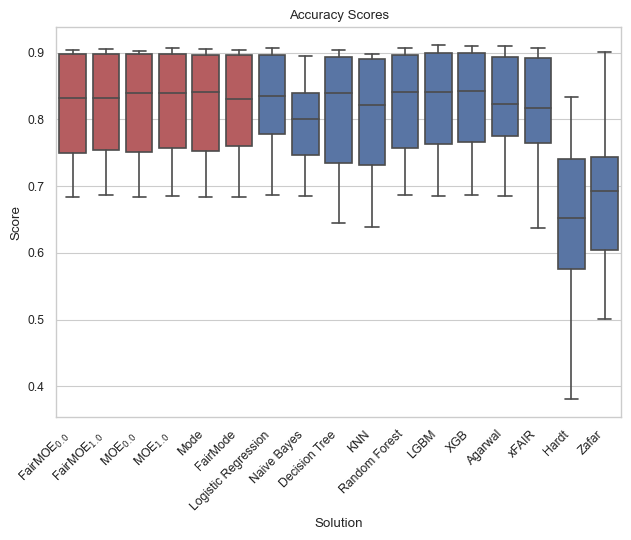

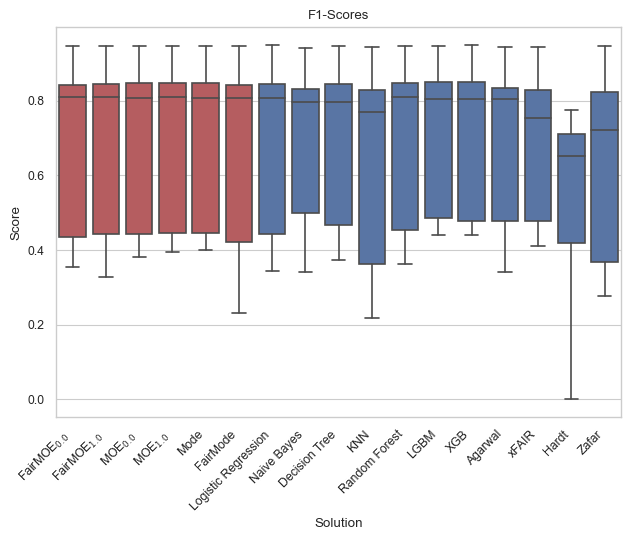

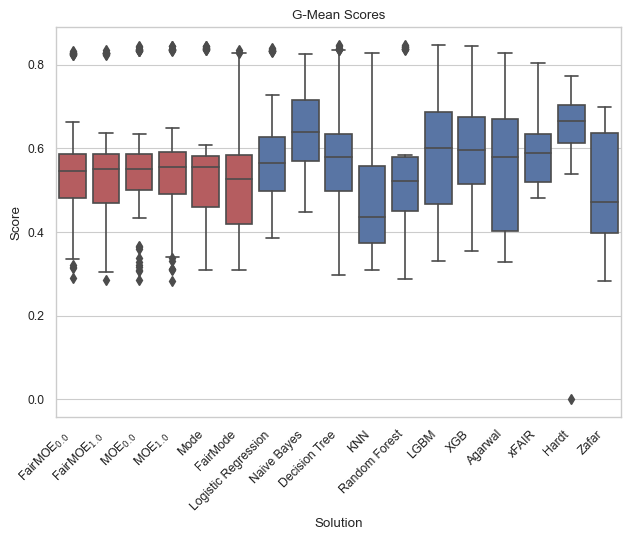

In [42]:
# sns.set(rc={'figure.figsize':(6,4)})
sns.set_theme("paper", "whitegrid", font_scale=1)

box = sns.boxplot(data=perf_graph_df[perf_graph_df['Metric']=='Accuracy'], y='Score', x='Solution', orient="v", palette=my_pal)
plt.xlabel("Solution")
plt.title("Accuracy Scores")
plt.ylabel("Score")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

box = sns.boxplot(data=perf_graph_df[perf_graph_df['Metric']=='F1-Score'], y='Score', x='Solution', orient="v", palette=my_pal)
plt.xlabel("Solution")
plt.title("F1-Scores")
plt.ylabel("Score")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

box = sns.boxplot(data=perf_graph_df[perf_graph_df['Metric']=='G-Mean'], y='Score', x='Solution', orient="v", palette=my_pal)
plt.xlabel("Solution")
plt.title("G-Mean Scores")
plt.ylabel("Score")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

### Fairness Performance

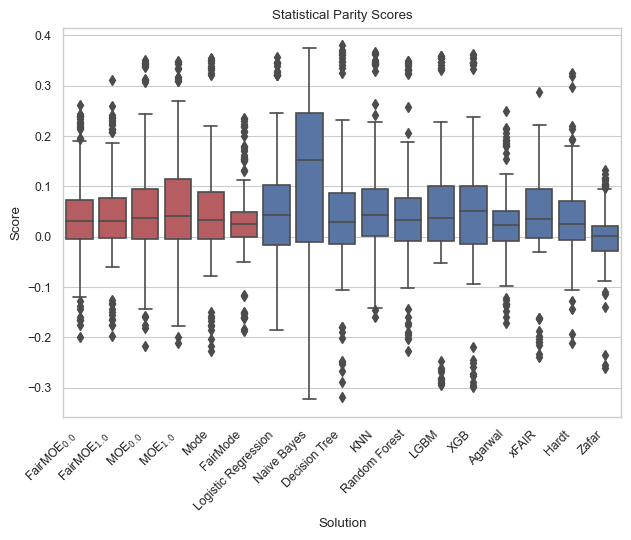

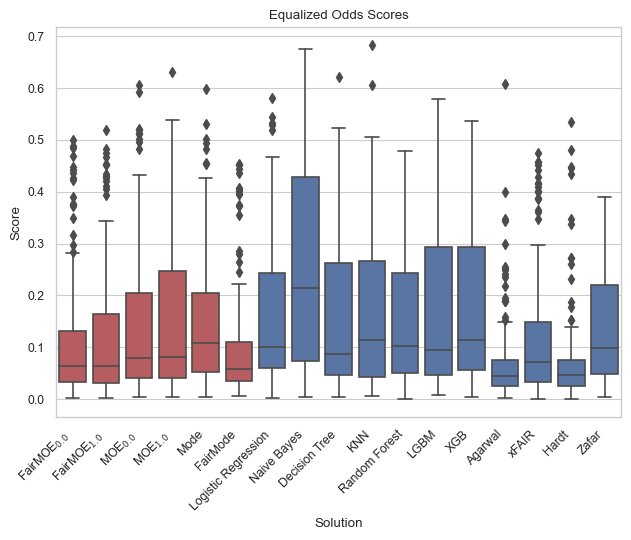

In [43]:
box = sns.boxplot(data=fair_graph_df[fair_graph_df['Metric']=='Statistical Parity'], y='Score', x='Solution', orient="v", palette=my_pal)
plt.xlabel("Solution")
plt.title("Statistical Parity Scores")
plt.ylabel("Score")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

box = sns.boxplot(data=fair_graph_df[fair_graph_df['Metric']=='Equalized Odds'], y='Score', x='Solution', orient="v", palette=my_pal)
plt.xlabel("Solution")
plt.title("Equalized Odds Scores")
plt.ylabel("Score")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

### Predictive Performance Sorted

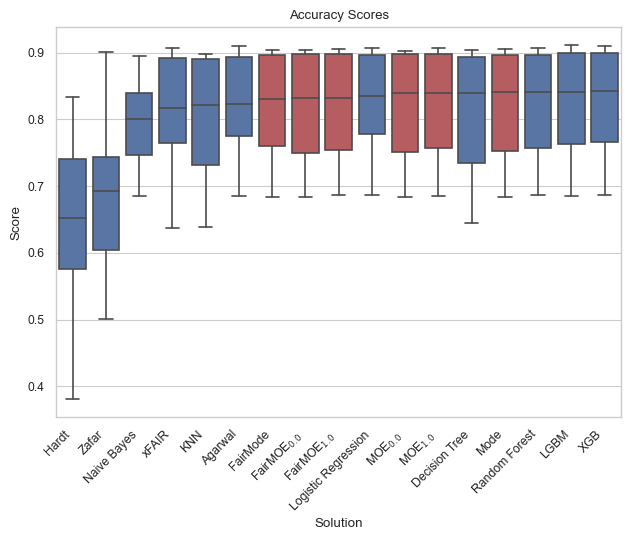

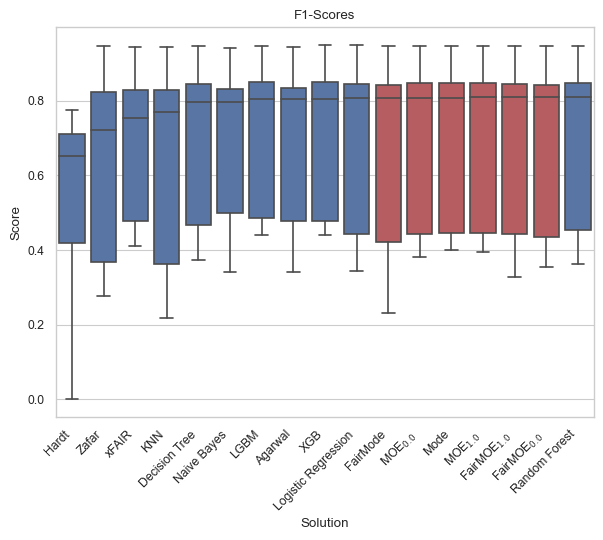

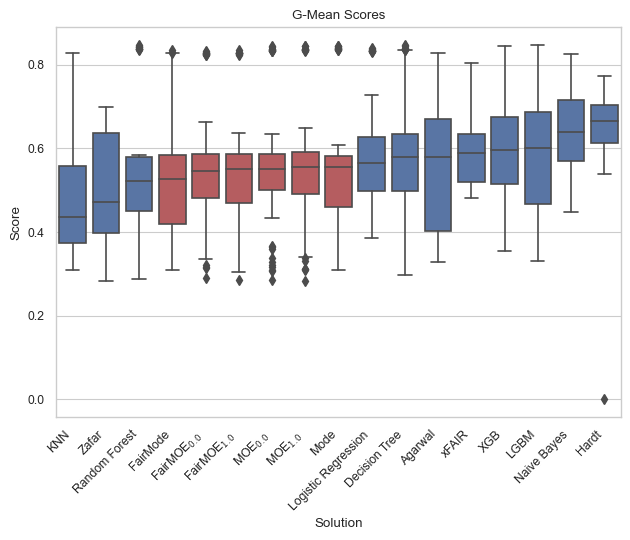

In [44]:
order = perf_graph_df.loc[perf_graph_df['Metric']=='Accuracy', ['Solution', 'Score']].groupby('Solution').median().apply(lambda x: x.sort_values(ascending=True)).index
box = sns.boxplot(data=perf_graph_df[perf_graph_df['Metric']=='Accuracy'], y='Score', x='Solution', orient="v", order=order, palette=my_pal)
plt.xlabel("Solution")
plt.title("Accuracy Scores")
plt.ylabel("Score")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

order = perf_graph_df.loc[perf_graph_df['Metric']=='F1-Score', ['Solution', 'Score']].groupby('Solution').median().apply(lambda x: x.sort_values(ascending=True)).index
box = sns.boxplot(data=perf_graph_df[perf_graph_df['Metric']=='F1-Score'], y='Score', x='Solution', orient="v", order=order, palette=my_pal)
plt.xlabel("Solution")
plt.title("F1-Scores")
plt.ylabel("Score")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

order = perf_graph_df.loc[perf_graph_df['Metric']=='G-Mean', ['Solution', 'Score']].groupby('Solution').median().apply(lambda x: x.sort_values(ascending=True)).index
box = sns.boxplot(data=perf_graph_df[perf_graph_df['Metric']=='G-Mean'], y='Score', x='Solution', orient="v", order=order, palette=my_pal)
plt.xlabel("Solution")
plt.title("G-Mean Scores")
plt.ylabel("Score")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

### Fairness Performance Sorted

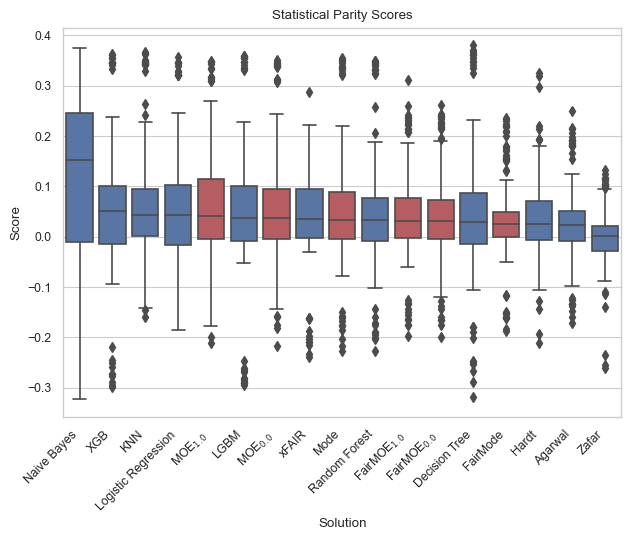

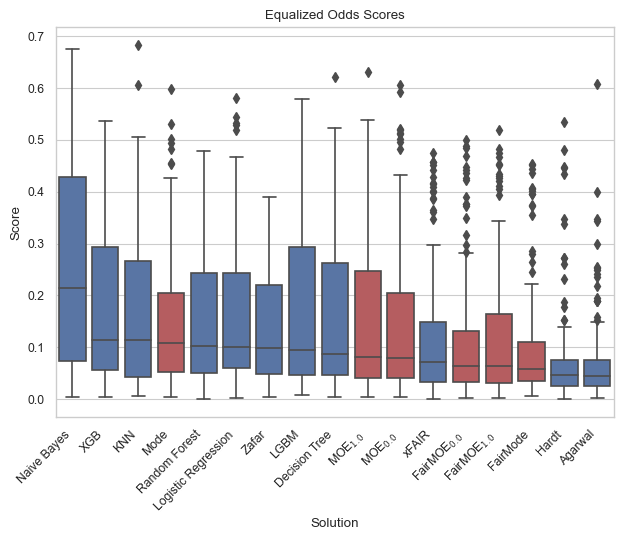

In [45]:
order = fair_graph_df.loc[fair_graph_df['Metric']=='Statistical Parity', ['Solution', 'Score']].groupby('Solution').median().apply(lambda x: x.sort_values(ascending=False)).index
box = sns.boxplot(data=fair_graph_df[fair_graph_df['Metric']=='Statistical Parity'], y='Score', x='Solution', orient="v", order=order, palette=my_pal)
plt.xlabel("Solution")
plt.title("Statistical Parity Scores")
plt.ylabel("Score")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

order = fair_graph_df.loc[fair_graph_df['Metric']=='Equalized Odds', ['Solution', 'Score']].groupby('Solution').median().apply(lambda x: x.sort_values(ascending=False)).index
box = sns.boxplot(data=fair_graph_df[fair_graph_df['Metric']=='Equalized Odds'], y='Score', x='Solution', orient="v", order=order, palette=my_pal)
plt.xlabel("Solution")
plt.title("Equalized Odds Scores")
plt.ylabel("Score")
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

## Fairness/Performance Trade-Off

In [26]:
perf_means = perf_ranks.mean(axis=1)
fair_means = fair_ranks.mean(axis=1)

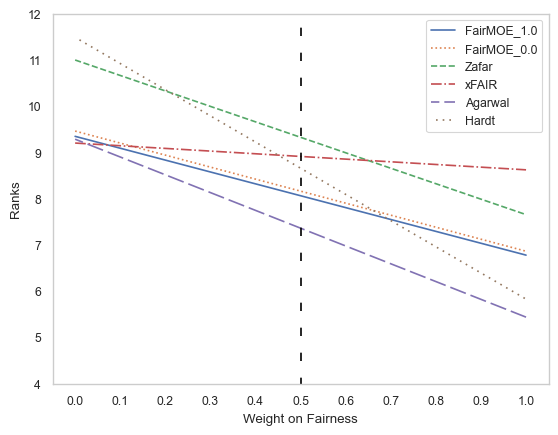

In [27]:
combo = {}
xs = np.linspace(0,1,101)
solutions_to_graph = ['FairMOE_1.0', 'FairMOE_0.0', 'Zafar', 'xFAIR', 'Agarwal', 'Hardt']

for solution in solutions_to_graph:
    combo[solution] = []
    for alpha in xs:
        combo[solution].append((1-alpha)*perf_means[solution] + alpha*fair_means[solution])

styles = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10,3)), (5, (1,3))]
cycler = cycle(styles)

for solution in solutions_to_graph:
    plt.plot(xs, combo[solution], label=solution, linestyle=next(cycler))
plt.legend()
plt.xlabel('Weight on Fairness')
plt.ylabel('Ranks')
plt.ylim((4, 12))
plt.grid(False)
plt.vlines(.5, color='xkcd:black', ymin=1, ymax=15, linestyle=(0, (5, 10)))
plt.xticks(np.linspace(0,1,11))
plt.show()

## NI Budget

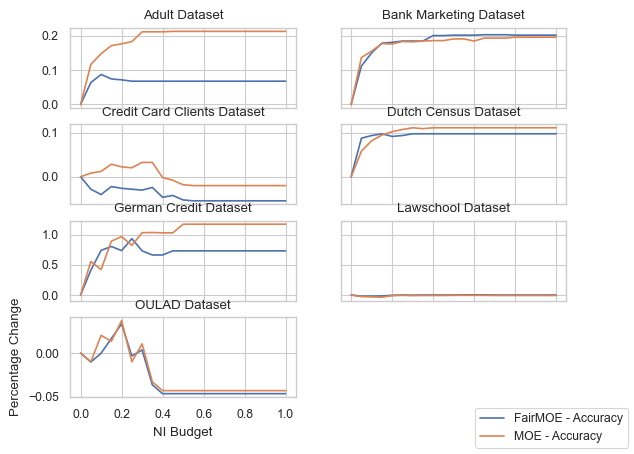

In [29]:
fig = plt.figure()
gs = fig.add_gridspec(4, 2)
(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) = gs.subplots(sharex='col', sharey='row')

ax1.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'adult', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'adult', 'acc_pct_diff'], label='FairMOE - Accuracy')
ax1.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'adult', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'adult', 'acc_pct_diff'], label='MOE - Accuracy')
ax1.set_title('Adult Dataset')

ax2.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'bank_marketing', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'bank_marketing', 'acc_pct_diff'], label='FairMOE - Accuracy')
ax2.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'bank_marketing', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'bank_marketing', 'acc_pct_diff'], label='MOE - Accuracy')
ax2.set_title('Bank Marketing Dataset')

ax3.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'credit_card_clients', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'credit_card_clients', 'acc_pct_diff'], label='FairMOE - Accuracy')
ax3.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'credit_card_clients', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'credit_card_clients', 'acc_pct_diff'], label='MOE - Accuracy')
ax3.set_title('Credit Card Clients Dataset')

ax4.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'dutch_census', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'dutch_census', 'acc_pct_diff'], label='FairMOE - Accuracy')
ax4.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'dutch_census', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'dutch_census', 'acc_pct_diff'], label='MOE - Accuracy')
ax4.set_title('Dutch Census Dataset')

ax5.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'german_credit', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'german_credit', 'acc_pct_diff'], label='FairMOE - Accuracy')
ax5.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'german_credit', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'german_credit', 'acc_pct_diff'], label='MOE - Accuracy')
ax5.set_title('German Credit Dataset')

ax6.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'lawschool', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'lawschool', 'acc_pct_diff'], label='FairMOE - Accuracy')
ax6.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'lawschool', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'lawschool', 'acc_pct_diff'], label='MOE - Accuracy')
ax6.set_title('Lawschool Dataset')

ax7.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'oulad', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'oulad', 'acc_pct_diff'], label='FairMOE - Accuracy')
ax7.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'oulad', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'oulad', 'acc_pct_diff'], label='MOE - F1')
ax7.set_title('OULAD Dataset')

fig.delaxes(ax8)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
plt.xlabel('NI Budget')
plt.ylabel('Percentage Change')
plt.show()

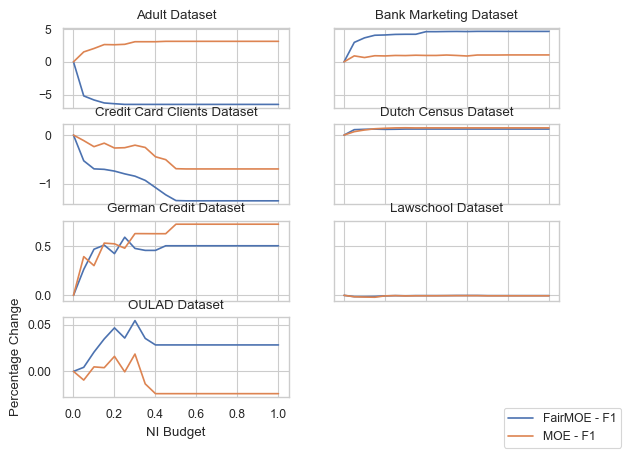

In [30]:
fig = plt.figure()
gs = fig.add_gridspec(4, 2)
(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) = gs.subplots(sharex='col', sharey='row')

ax1.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'adult', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'adult', 'f1_pct_diff'], label='FairMOE - F1')
ax1.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'adult', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'adult', 'f1_pct_diff'], label='MOE - F1')
ax1.set_title('Adult Dataset')

ax2.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'bank_marketing', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'bank_marketing', 'f1_pct_diff'], label='FairMOE - F1')
ax2.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'bank_marketing', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'bank_marketing', 'f1_pct_diff'], label='MOE - F1')
ax2.set_title('Bank Marketing Dataset')

ax3.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'credit_card_clients', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'credit_card_clients', 'f1_pct_diff'], label='FairMOE - F1')
ax3.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'credit_card_clients', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'credit_card_clients', 'f1_pct_diff'], label='MOE - F1')
ax3.set_title('Credit Card Clients Dataset')

ax4.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'dutch_census', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'dutch_census', 'f1_pct_diff'], label='FairMOE - F1')
ax4.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'dutch_census', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'dutch_census', 'f1_pct_diff'], label='MOE - F1')
ax4.set_title('Dutch Census Dataset')

ax5.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'german_credit', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'german_credit', 'f1_pct_diff'], label='FairMOE - F1')
ax5.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'german_credit', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'german_credit', 'f1_pct_diff'], label='MOE - F1')
ax5.set_title('German Credit Dataset')

ax6.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'lawschool', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'lawschool', 'f1_pct_diff'], label='FairMOE - F1')
ax6.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'lawschool', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'lawschool', 'f1_pct_diff'], label='MOE - F1')
ax6.set_title('Lawschool Dataset')

ax7.plot(budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'oulad', 'Budget'], budget_res_fairmoe.loc[budget_res_fairmoe['Dataset']== 'oulad', 'f1_pct_diff'], label='FairMOE - Accuracy')
ax7.plot(budget_res_moe.loc[budget_res_moe['Dataset']== 'oulad', 'Budget'], budget_res_moe.loc[budget_res_moe['Dataset']== 'oulad', 'f1_pct_diff'], label='MOE - F1')
ax7.set_title('OULAD Dataset')

fig.delaxes(ax8)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
plt.xlabel('NI Budget')
plt.ylabel('Percentage Change')
plt.show()

### Amount Used

In [34]:
fairmoe_used_budget = {}
moe_used_budget = {}

budgets = [0.00, 0.05, .10, 0.15, .20, 0.25, .30, 0.35, .40, 0.45, .50, 0.55, .60, 0.65, .70, 0.75, .80, 0.85, .90, 0.95, 1.00]
for dataset in datasets:
    fairmoe_used_budget[dataset] = {}
    moe_used_budget[dataset] = {}
    for budget in budgets:
        fairmoe_used_budget[dataset][budget] = []
        moe_used_budget[dataset][budget] = []

int_models = ['Decision_Tree', 'Naive_Bayes', 'Logistic_Regression', 'KNN']
non_int_models = ['Random_Forest', 'LGBM', 'XGB']

for i in range(budget_res.shape[0]):
    int_preds_cnt = 0
    non_int_preds_cnt = 0
    for model in budget_res.loc[i, 'Selected Models']:
        if model in int_models:
            int_preds_cnt += 1
        elif model in non_int_models:
            non_int_preds_cnt += 1
        else:
            raise ValueError(f"Joe you missed this model you dumbass: {model}")
    if budget_res.loc[i, 'Model'] == 'FairMOE':
        fairmoe_used_budget[budget_res.loc[i, 'Dataset']][budget_res.loc[i, 'Budget']].append(non_int_preds_cnt/(int_preds_cnt+non_int_preds_cnt))
    elif budget_res.loc[i, 'Model'] == 'MOE':
        moe_used_budget[budget_res.loc[i, 'Dataset']][budget_res.loc[i, 'Budget']].append(non_int_preds_cnt/(int_preds_cnt+non_int_preds_cnt))

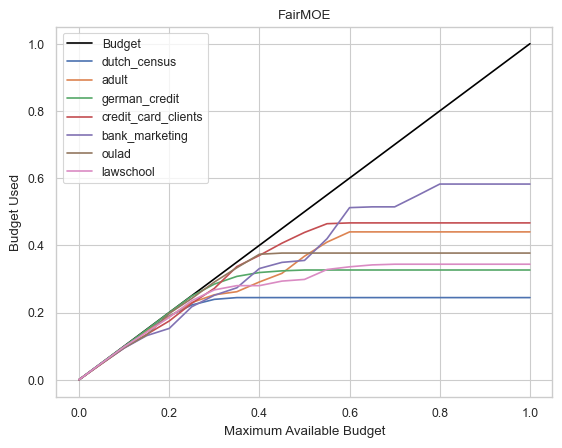

In [35]:
plt.plot(budgets, budgets, color='black', label='Budget')
for dataset in datasets:
    avgs = []
    for budget in budgets:
        avgs.append(np.mean(fairmoe_used_budget[dataset][budget]))
    plt.plot(budgets, avgs, label=dataset)
plt.legend()
plt.title("FairMOE")
plt.ylabel("Budget Used")
plt.xlabel("Maximum Available Budget")
plt.show()

In [37]:
fairmoe_nums = []
moe_nums = []
for dataset in datasets:
        fairmoe_nums.extend(fairmoe_used_budget[dataset][1.0])
        moe_nums.extend(moe_used_budget[dataset][1.0])        

In [38]:
print(fairmoe_nums)
print(moe_nums)

[0.3204237007613373, 0.19414101290963257, 0.26936444885799404, 0.3310162197947699, 0.12917907977490897, 0.24619331347236015, 0.19198940748096657, 0.24064879179079776, 0.23535253227408143, 0.2855014895729891, 0.23482587064676616, 0.28004422332780543, 0.4540630182421227, 0.5765616362631288, 0.5512437810945273, 0.46766169154228854, 0.5143173023770039, 0.3529021558872305, 0.42775013819789937, 0.5399668325041459, 0.26, 0.305, 0.27, 0.325, 0.475, 0.24, 0.375, 0.385, 0.355, 0.275, 0.4736666666666667, 0.5091666666666667, 0.3408333333333333, 0.48033333333333333, 0.3865, 0.5618333333333333, 0.5368333333333334, 0.488, 0.489, 0.4008333333333333, 0.3802941501714033, 0.5606546500055292, 0.5814442109919274, 0.587083932323344, 0.6020126064359173, 0.3672453831693022, 0.5975892955877474, 0.7655645250469977, 0.7600353864867854, 0.6210328430830476, 0.39508462786923254, 0.40064920009274285, 0.34987247855321124, 0.38836076976582423, 0.3976350568050081, 0.3447716206816601, 0.3533503361929052, 0.3851147693021

In [39]:
np.mean(fairmoe_nums)

0.39721293914250083

In [40]:
np.mean(moe_nums)

0.4000992276225015